# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib torch torchvision tqdm
```

In [1]:
#docker run -it --rm --restart=always --name ml --runtime nvidia nvcr.io/nvidia/l4t-ml:r32.4.3-py3
apt-get install libpng-dev libfreetype6-dev
pip3 uninstall pillow
pip3 install pillow --global-option="build_ext" --global-option="--enable-freetype" --global-option="--debug"
pip3 install pillow --no-cache-dir
pip3 install captcha numpy matplotlib torch torchvision tqdm

    100% |################################| 102kB 243kB/s a 0:00:01
    100% |################################| 71kB 581kB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict

import string
characters = '-' + string.digits + string.ascii_uppercase
width, height, n_len, n_classes = 192, 64, 4, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 192 64 4 37


# 搭建数据集

In [2]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

# 测试数据集

YNT2 tensor([12]) tensor([4])


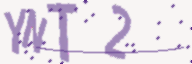

In [3]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

# 初始化数据集生成器

In [4]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)

# 搭建模型

In [5]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

## 测试模型输出尺寸

In [6]:
model = Model(n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = model(inputs)
outputs.shape

torch.Size([12, 32, 37])

## 初始化模型

In [7]:
model = Model(n_classes, input_shape=(3, height, width))
model = model.cuda()
model

Model(
  (cnn): Sequential(
    (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu11): ReLU(inplace=True)
    (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu12): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn21): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu21): ReLU(inplace=True)
    (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu22): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

# 解码函数和准确率计算函数

In [8]:
def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

# 训练模型

In [12]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [13]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)
epochs = 30
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

  0%|          | 0/1000 [00:10<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-4aa98fc4a0ab>", line 4, in <module>
    train(model, optimizer, epoch, train_loader)
  File "<ipython-input-12-4dcd70a86e84>", line 6, in train
    for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1130, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 354, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 980, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1005, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.6/dist-pack

TypeError: object of type 'NoneType' has no len()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

  0%|          | 0/1000 [00:07<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 187) exited unexpectedly

# 测试模型输出

true: ZOGI
pred: ZOGI
true: GK3U
pred: GK3U
true: A00R
pred: A00R
true: JM4N
pred: JM4N
true: W838
pred: W838
true: 75YH
pred: 75YH
true: 12V6
pred: 12V6
true: LV6O
pred: LV6O
true: EVAL
pred: EVAL
true: XI2D
pred: XI2D
true: QWQS
pred: QWQS
true: FJXV
pred: FJXV
true: T4GO
pred: T4GO
true: 8WIR
pred: 8WIR
true: W447
pred: W447
true: 7YFO
pred: 7YFO
true: AN3I
pred: AN3I
true: VQTD
pred: VQTD
true: TY1R
pred: TY1R
true: XCG7
pred: XCG7
true: FW3Z
pred: FW3Z
true: XK5H
pred: XK5H
true: BR74
pred: BR74
true: XMR6
pred: XMR6
true: LP4T
pred: LP4T
true: ZYZO
pred: ZYZO
true: 7IUL
pred: 7IUL
true: KGXF
pred: KGXF
true: L3CR
pred: L3CR
true: 1N9T
pred: 1N9T
true: WA0U
pred: WA0U
true: 1RPS
pred: 1RPS
true: QPNI
pred: QPNI
true: U514
pred: U514
true: TMNX
pred: TMNX
true: ZT7U
pred: ZT7U
true: VFM1
pred: VFM1
true: Z956
pred: Z956
true: ETAD
pred: ETAD
true: GQTX
pred: GQTX
true: MQMB
pred: MQMB
true: BJLD
pred: BJLD
true: AI8N
pred: AI8N
true: 2JGW
pred: 2JGW
true: 919J
pred: 919J
true: 6S5T

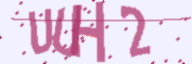

In [16]:
model = torch.load('ctc.pth')
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]
    print('true:', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    print('pred:', decode(output_argmax[0]))
to_pil_image(image)

In [15]:
torch.save(model, 'ctc.pth')